Разведочный анализ Dataset Tytanic

Импортируем датасет,и выставляем нужные настройки

In [41]:
import pygam
from pygam import LinearGAM, s, f, l
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, s, f, l
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, fbeta_score, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC



# Установка опций отображения pandas
pd.set_option('display.max_columns', None)

# Загрузка данных
gender_submission = pd.read_csv("gender_submission.csv")
train = pd.read_csv("train.csv")
print(train.shape)
test = pd.read_csv("test.csv")
print(test.shape)
# Объединение данных
test_1 = pd.merge(test, gender_submission, on='PassengerId', how='outer')
data = pd.concat([test_1, train])



(891, 12)
(418, 11)


### 1.Ознакомительная часть разведочного анализа

Демонстируем первые 5 строк датасета

In [42]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


Датасет имеет следующие размеры 1309 строк на 12 столбцов(признаков)

In [43]:
data.shape

(1309, 12)

Описываем статистические характеристики для каждого из признаков

In [45]:
data.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
count,1309.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307,1309.000000
unique,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3,NaN
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S,NaN
freq,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914,NaN
mean,655.000000,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN,0.377387
std,378.020061,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN,0.484918
min,1.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000
25%,328.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,0.000000
50%,655.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,0.000000
75%,982.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN,1.000000


Описываем тип данных для каждого из признаков

In [46]:
data.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Survived         int64
dtype: object

## 2.Пропуски и обработка пропусков в датасете

Укажем количество пропусков по каждому признаку,соотношение к общему количество признаков по и датасету столбцу
,а также тип данных этого признака

In [47]:
data_na=pd.DataFrame({'counts':data.isnull().sum()[data.isnull().sum() > 0]})
data_na['proсent_na of dataset']=data_na['counts']/data_na['counts'].sum()*100
data_na['dtype']=data.dtypes[data.isnull().sum() > 0]
data_na['proсent_na of predictor']=data_na['counts']/data.shape[0]
print(data_na.sort_values('counts'))

          counts  proсent_na of dataset    dtype  proсent_na of predictor
Fare           1               0.078125  float64                 0.000764
Embarked       2               0.156250   object                 0.001528
Age          263              20.546875  float64                 0.200917
Cabin       1014              79.218750   object                 0.774637


Из отсортированный выше таблицы мы можем сделать следующие выводы,что основную массу пропусков занимают значения
из признаков Cabin(Номер кабины),Age(Возраст),Embarked(Порт посадки),Fare(Цена билета)
Замена будет происходить следующим образом:
Столбец Cabin будет удален из-за отсутствия большей части данных.
Пропуски Age,Fare,Embarked будут заменены на медиану и моду соотственно после анализа распределения данных и изучения выбросов


In [48]:
data_new=pd.DataFrame({'Значение в датасете':['Cabin', 'Age', 'Embarked', 'Fare'],
                       'Перевод на русский' :['Номер кабины', 'Возраст', 'Порт посадки', 'Цена билета', ],
                      'Тип значения':['категориальное значение', 'непрерывное значение', 'категориальное значение', 'непрерывное значение'],
                        'замена':['удаление стобца', 'замена средним значением', 'замена модой', 'замена средним значением']
                       })
print(data_new)


  Значение в датасете Перевод на русский             Тип значения  \
0               Cabin       Номер кабины  категориальное значение   
1                 Age            Возраст     непрерывное значение   
2            Embarked       Порт посадки  категориальное значение   
3                Fare        Цена билета     непрерывное значение   

                     замена  
0           удаление стобца  
1  замена средним значением  
2              замена модой  
3  замена средним значением  


# 3.Распределение признаков

Распределение непрерывных признаков(ticket,PassengerId,Name исключим из-за отсутствия применимости)

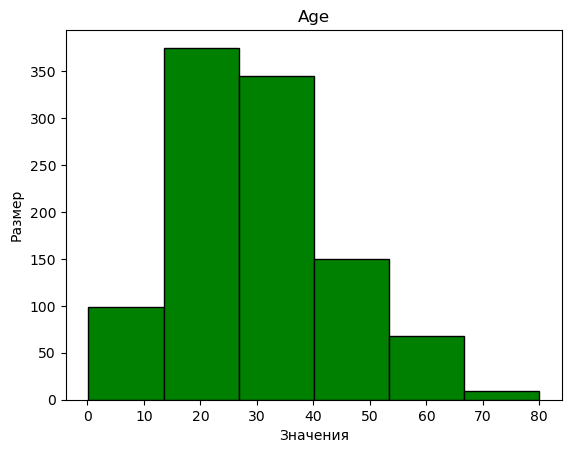

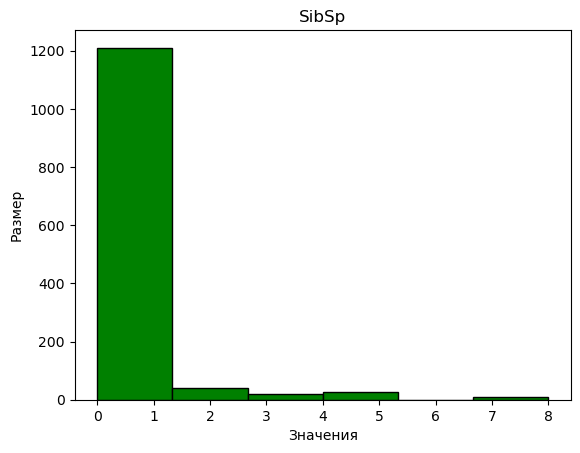

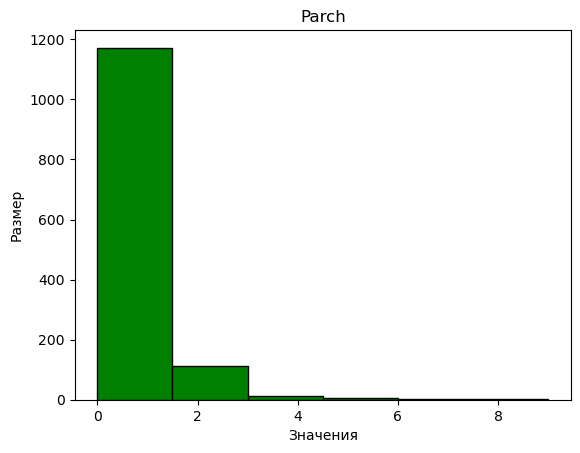

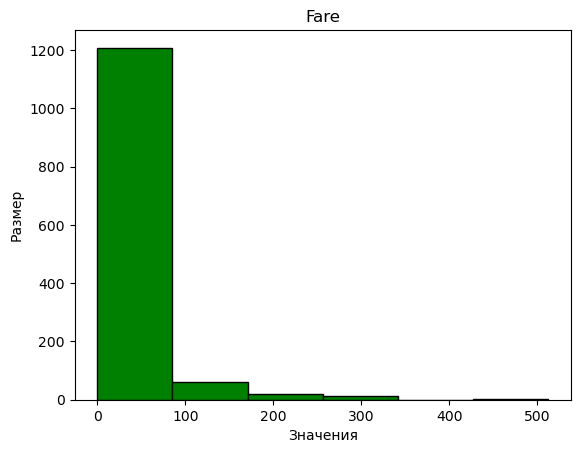

In [49]:
float_columns=['Age','SibSp','Parch','Fare']
for i in float_columns:
    plt.hist(data[i],color='green',bins=6,rwidth=10,edgecolor='black')
    plt.title(i)
    plt.xlabel('Значения')
    plt.ylabel('Размер')
    plt.show()

Из анализа гистограмм мы можем понять,что признак Age имеет распределение близкое к нормальному,
стоимость большинства билетов составляла до 100$,а пассажиров имели по 1-2 родственника на корабле.

Распределение категориальных признаков

Основная масса билетов куплена для 3го класса,большинство пассажиров мужчины,а основной порт Саутгемптон

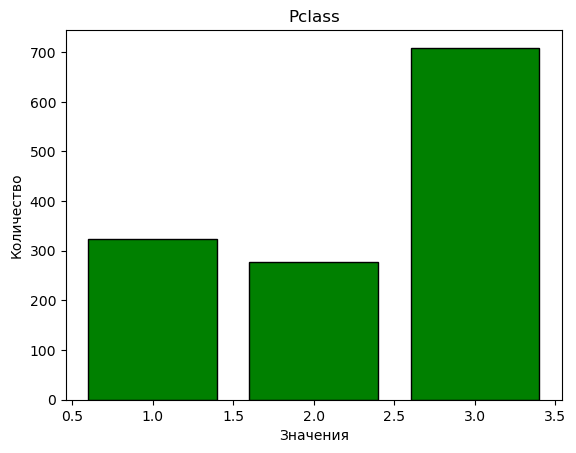

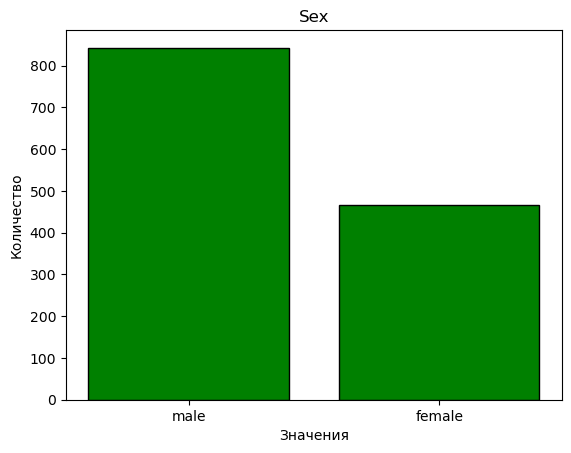

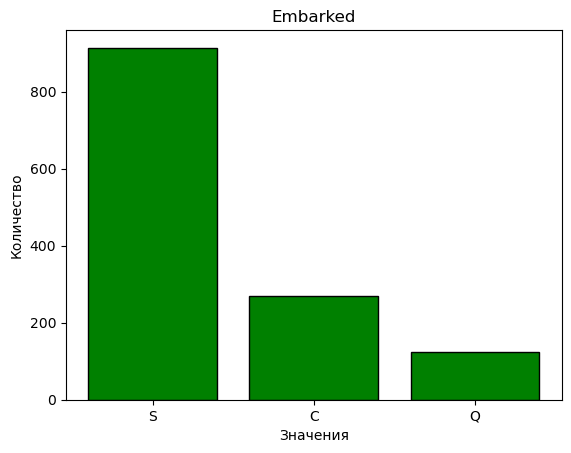

In [50]:
object_columns=['Pclass','Sex','Embarked']
for i in object_columns:
    # Построение столбчатой диаграммы
    plt.bar(data[i].value_counts().index,data[i].value_counts(),color='green',edgecolor='black')

    # Настройка заголовка и меток осей
    plt.title(i)
    plt.xlabel('Значения')
    plt.ylabel('Количество')
    plt.show()


# 4.Выбросы

Изучим количественные переменные

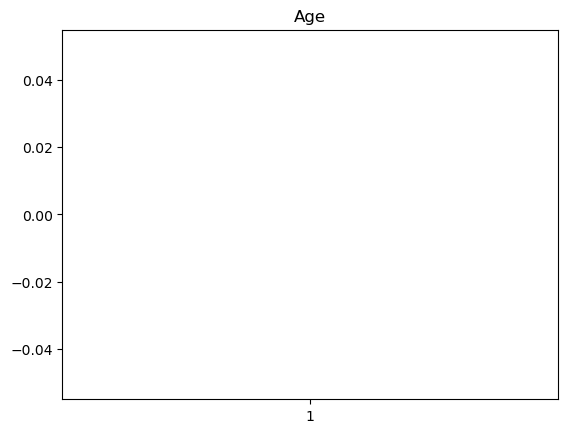

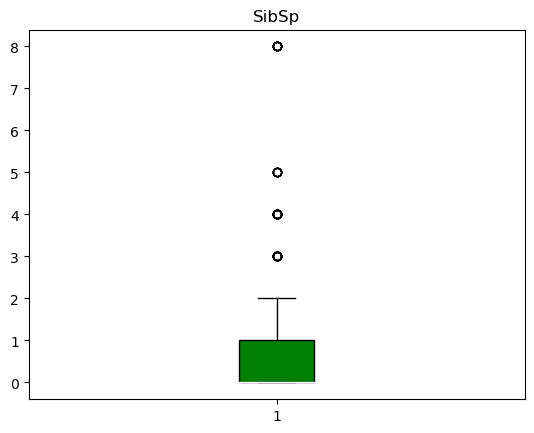

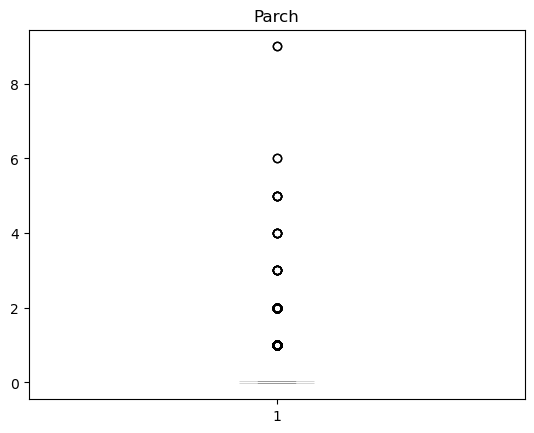

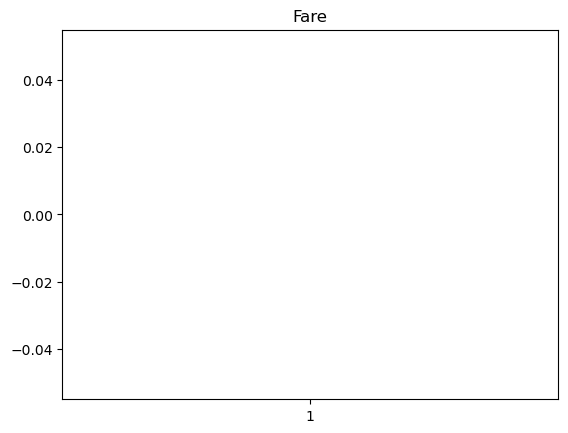

In [51]:
float_columns=['Age','SibSp','Parch','Fare']
for i in float_columns:
    plt.boxplot(data[i],
                patch_artist=True,  
                boxprops=dict(facecolor='green', color='black'),  
                medianprops=dict(color='white'))
    plt.title(i)
    plt.show()

    

По столбцам Age и Fare не построился boxplot из за преобладания малого количества значений,
в SibSP мы проведем удаление выбросов,Parch оставим как есть по причине из-за преобладания малого количества значений
а также проведем замену значений

In [58]:
data['SibSp']=data['SibSp'].clip(lower=0,upper=2)
data['Age']=data['Age'].fillna(data['Age'].mean())
data['Embarked']=data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Fare']=data['Fare'].fillna(data['Fare'].mean())


# 5.Корреляция признаков

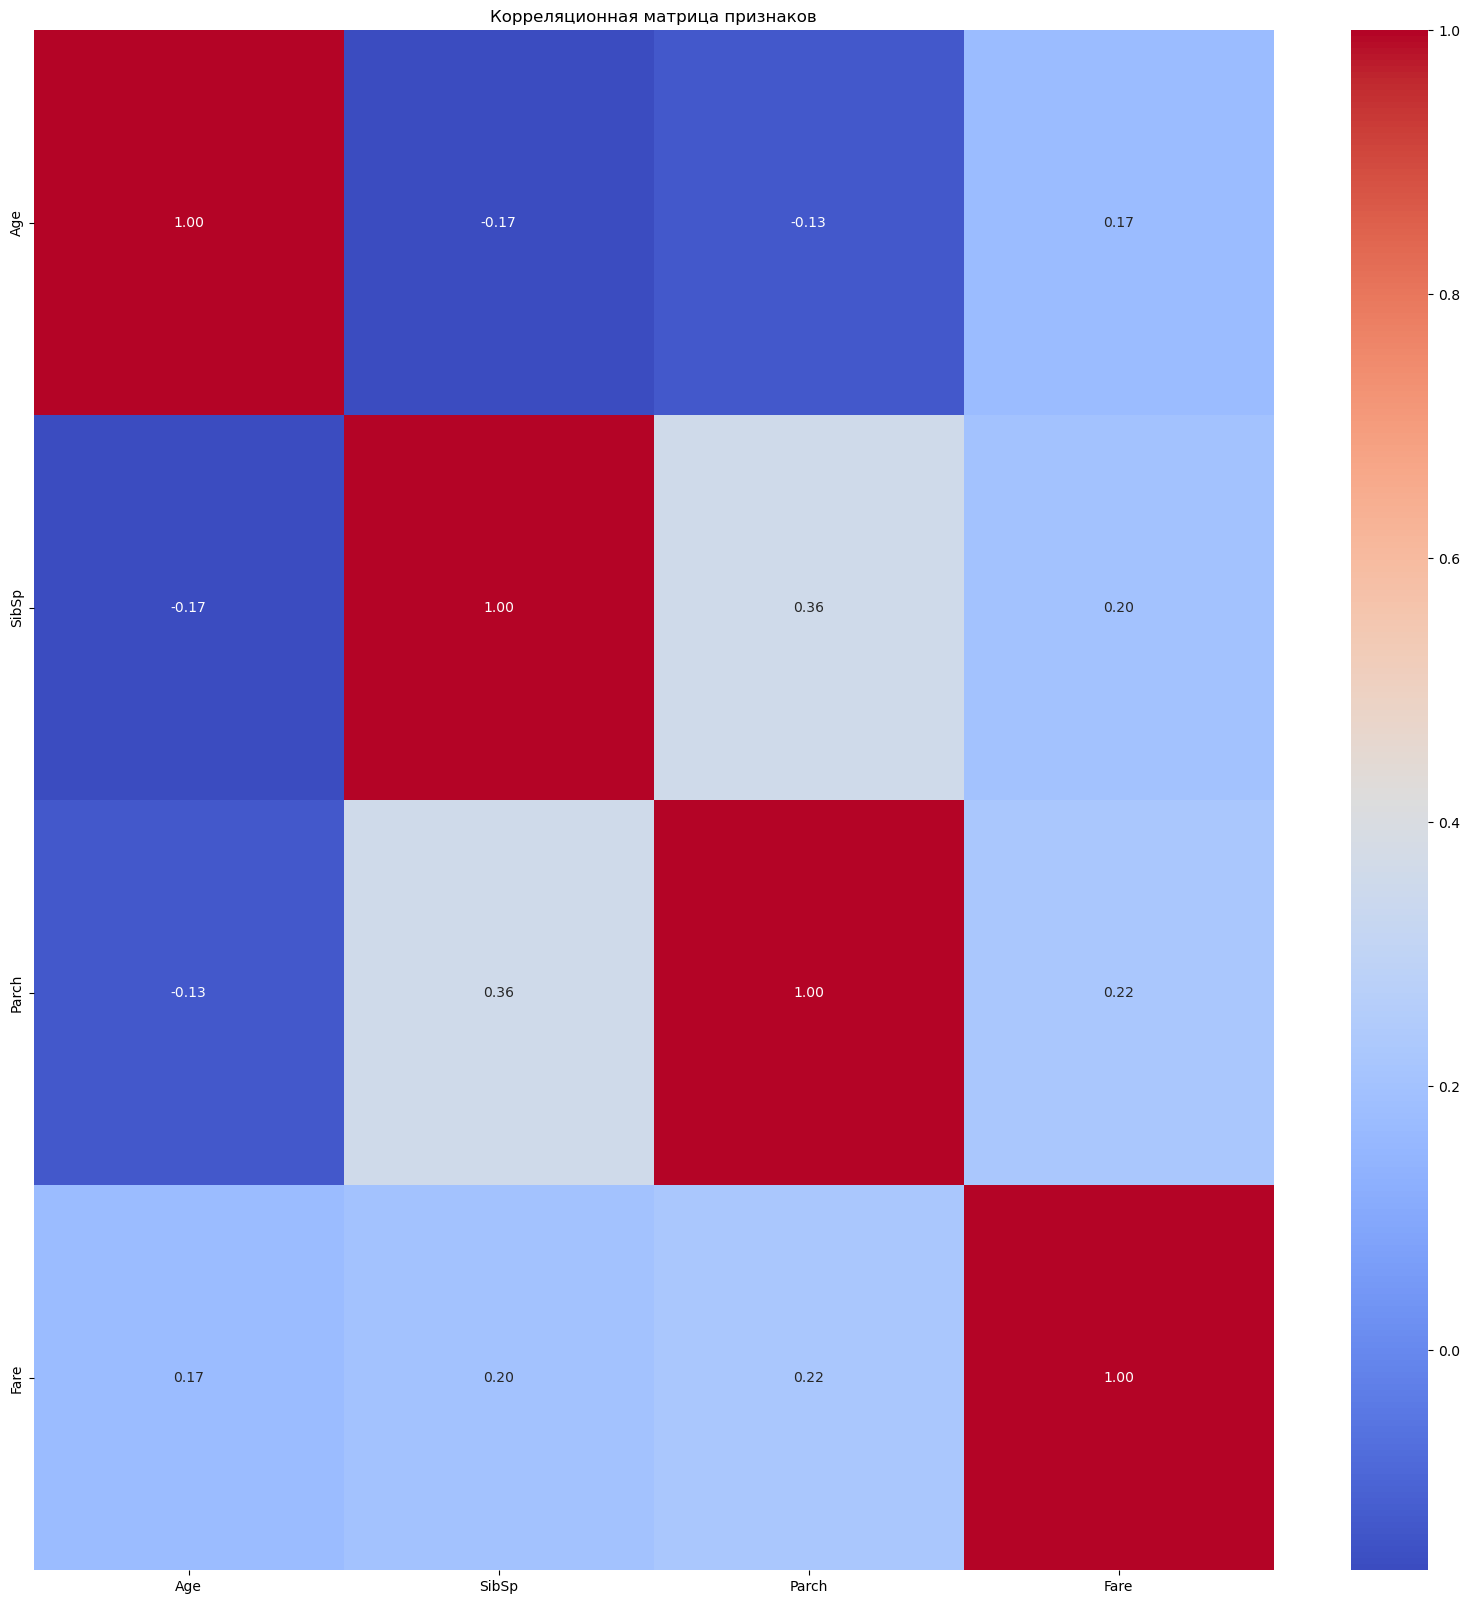

In [59]:
corr_matrix = data[['Age', 'SibSp', 'Parch', 'Fare']].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица признаков')
plt.show()


Данная матрица показывает среднюю положительную корреляцию между Parch и Sibcb,
и слабую отрицательную между Age и Sibcb 

Наивный байес

In [61]:
bins=[-1,130,260,390,520]
labels = ['0-130', '131-260', '261-390', '391-520']
data['Fare_Category']=pd.cut(data['Fare'],bins=bins,labels=labels)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
labels = ['0-10','11-20','21-30','31-40','41-50', '51-60','61-70','71-80']
data['Age_Category']=pd.cut(data['Age'],bins=bins,labels=labels)
bins=[0,1,2,3]
labels = ['First class', 'Second class', 'Third class']
data['Pclass_Category']=pd.cut(data['Pclass'],bins=bins,labels=labels)

Разобьем после подготовки данных заново датасет на две части,train и test

In [73]:
predictors = ['Age_Category', 'Fare_Category', 'SibSp', 'Parch', 'Pclass_Category', 'Sex', 'Embarked']
outcome = ['Survived']

train = data.iloc[:891]
test = data.iloc[891:]

X_train = pd.get_dummies(train[predictors])
Y_train = train[outcome].values.ravel()

naive_model = MultinomialNB(alpha=0.02, fit_prior=True)
naive_model.fit(X_train, Y_train)

y_pred_train = naive_model.predict(X_train).ravel()
naive_list_train = [
    accuracy_score(Y_train, y_pred_train),
    fbeta_score(Y_train, y_pred_train, beta=1),
    f1_score(Y_train, y_pred_train),
    precision_score(Y_train, y_pred_train),
    recall_score(Y_train, y_pred_train),
    roc_auc_score(Y_train, y_pred_train)
]

X_test = pd.get_dummies(test[predictors])
Y_test = test[outcome].values.ravel()

y_pred_test = naive_model.predict(X_test).ravel()
naive_list_test = [
    accuracy_score(Y_test, y_pred_test),
    fbeta_score(Y_test, y_pred_test, beta=1),
    f1_score(Y_test, y_pred_test),
    precision_score(Y_test, y_pred_test),
    recall_score(Y_test, y_pred_test),
    roc_auc_score(Y_test, y_pred_test)
]

print(naive_list_train)
print(naive_list_test)


[0.8855218855218855, 0.849112426035503, 0.849112426035503, 0.849112426035503, 0.849112426035503, 0.8784440972853825]
[0.777511961722488, 0.6847457627118644, 0.6847457627118644, 0.7266187050359713, 0.6474358974358975, 0.7511988647484831]


In [81]:
lda_model=LinearDiscriminantAnalysis()
lda_model.fit(X_train,Y_train)
y_pred_train = lda_model.predict(X_train)
lda_list_train= [
    accuracy_score(Y_train, y_pred_train),
    fbeta_score(Y_train, y_pred_train,beta=1),
    f1_score(Y_train, y_pred_train),
    precision_score(Y_train, y_pred_train),
    recall_score(Y_train, y_pred_train),
    roc_auc_score(Y_train, y_pred_train)
]
y_pred_test=lda_model.predict(X_test)
lda_list_test=[
    accuracy_score(Y_test, y_pred_test),
    fbeta_score(Y_test, y_pred_test, beta=1),
    f1_score(Y_test, y_pred_test),
    precision_score(Y_test, y_pred_test),
    recall_score(Y_test, y_pred_test),
    roc_auc_score(Y_test, y_pred_test)
]

print(lda_list_train)
print(lda_list_test)


[0.8933782267115601, 0.8575712143928035, 0.8575712143928035, 0.8693009118541033, 0.8461538461538461, 0.8841980804006121]
[0.7727272727272727, 0.6757679180887372, 0.6757679180887372, 0.7226277372262774, 0.6346153846153846, 0.7447886083382267]


In [82]:
logit_reg=LogisticRegression(penalty='l2',C=1e42, solver='liblinear')
logit_reg.fit(X_train,Y_train)
y_pred_train=logit_reg.predict(X_train)
logit_reg_list_train = [
    accuracy_score(Y_train, y_pred_train),
    fbeta_score(Y_train, y_pred_train,beta=1),
    f1_score(Y_train, y_pred_train),
    precision_score(Y_train, y_pred_train),
    recall_score(Y_train, y_pred_train),
    roc_auc_score(Y_train, y_pred_train)
]
y_pred_test=lda_model.predict(X_test)
logit_reg_list_test=[
    accuracy_score(Y_test, y_pred_test),
    fbeta_score(Y_test, y_pred_test, beta=1),
    f1_score(Y_test, y_pred_test),
    precision_score(Y_test, y_pred_test),
    recall_score(Y_test, y_pred_test),
    roc_auc_score(Y_test, y_pred_test)
]

print(logit_reg_list_train)
print(logit_reg_list_test)

[0.8945005611672279, 0.8592814371257484, 0.8592814371257484, 0.8696969696969697, 0.849112426035503, 0.8856773703414405]
[0.7727272727272727, 0.6757679180887372, 0.6757679180887372, 0.7226277372262774, 0.6346153846153846, 0.7447886083382267]


In [ ]:
Gam модель

In [84]:
gam = LinearGAM().fit(X_train, Y_train)
y_pred_train = gam.predict(X_train)
y_pred_num_train = np.array([1 if i > 0.5 else 0 for i in y_pred_train])

gam_list_train = [
    accuracy_score(Y_train, y_pred_num_train),
    fbeta_score(Y_train, y_pred_num_train, beta=1),
    f1_score(Y_train, y_pred_num_train),
    precision_score(Y_train, y_pred_num_train),
    recall_score(Y_train, y_pred_num_train),
    roc_auc_score(Y_train, y_pred_num_train)
]

y_pred_test = gam.predict(X_test)
y_pred_num_test = np.array([1 if i > 0.5 else 0 for i in y_pred_test])

gam_list_test = [
    accuracy_score(Y_test, y_pred_num_test),
    fbeta_score(Y_test, y_pred_num_test, beta=1),
    f1_score(Y_test, y_pred_num_test),
    precision_score(Y_test, y_pred_num_test),
    recall_score(Y_test, y_pred_num_test),
    roc_auc_score(Y_test, y_pred_num_test)
]

print(gam_list_train)
print(gam_list_test)


[0.8933782267115601, 0.8575712143928035, 0.8575712143928035, 0.8693009118541033, 0.8461538461538461, 0.8841980804006121]
[0.7727272727272727, 0.6757679180887372, 0.6757679180887372, 0.7226277372262774, 0.6346153846153846, 0.7447886083382267]


<!-- Метод опорных векторов -->

In [86]:
svc = SVC(kernel='poly')
svc.fit(X_train, Y_train)
y_pred_train = svc.predict(X_train)

svc_list_train = [
    accuracy_score(Y_train, y_pred_train),
    fbeta_score(Y_train, y_pred_train, beta=1),
    f1_score(Y_train, y_pred_train),
    precision_score(Y_train, y_pred_train),
    recall_score(Y_train, y_pred_train),
    roc_auc_score(Y_train, y_pred_train)
]

y_pred_test = svc.predict(X_test)

svc_list_test = [
    accuracy_score(Y_test, y_pred_test),
    fbeta_score(Y_test, y_pred_test, beta=1),
    f1_score(Y_test, y_pred_test),
    precision_score(Y_test, y_pred_test),
    recall_score(Y_test, y_pred_test),
    roc_auc_score(Y_test, y_pred_test)
]

print(svc_list_train)
print(svc_list_test)


[0.9057239057239057, 0.874251497005988, 0.874251497005988, 0.8848484848484849, 0.863905325443787, 0.8975946157056186]
[0.7966507177033493, 0.7058823529411764, 0.7058823529411764, 0.7669172932330827, 0.6538461538461539, 0.7677627715795654]


In [ ]:
III.Анализ метрик и итоговые выводы

In [ ]:
Покажем все имеющиеся метрики

In [89]:
metrics= pd.DataFrame({
    'MultinomialNB_train': naive_list_train,
    'MultinomialNB_test': naive_list_test,
    'LinearDiscriminantAnalysis_train': lda_list_train,
    'LinearDiscriminantAnalysis_test': lda_list_test,
    'LogisticRegression_train': logit_reg_list_train,
    'LogisticRegression_test': logit_reg_list_test,
    'LinearGAM_train': gam_list_train,
    'LinearGAM_test': gam_list_test,
    'SVC_train': svc_list_train,
    'SVC_test': svc_list_test
}, index=['accuracy_score', 'fbeta_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score'])

print(metrics)

                 MultinomialNB_train  MultinomialNB_test  \
accuracy_score              0.885522            0.777512   
fbeta_score                 0.849112            0.684746   
f1_score                    0.849112            0.684746   
precision_score             0.849112            0.726619   
recall_score                0.849112            0.647436   
roc_auc_score               0.878444            0.751199   

                 LinearDiscriminantAnalysis_train  \
accuracy_score                           0.893378   
fbeta_score                              0.857571   
f1_score                                 0.857571   
precision_score                          0.869301   
recall_score                             0.846154   
roc_auc_score                            0.884198   

                 LinearDiscriminantAnalysis_test  LogisticRegression_train  \
accuracy_score                          0.772727                  0.894501   
fbeta_score                             0.675768   

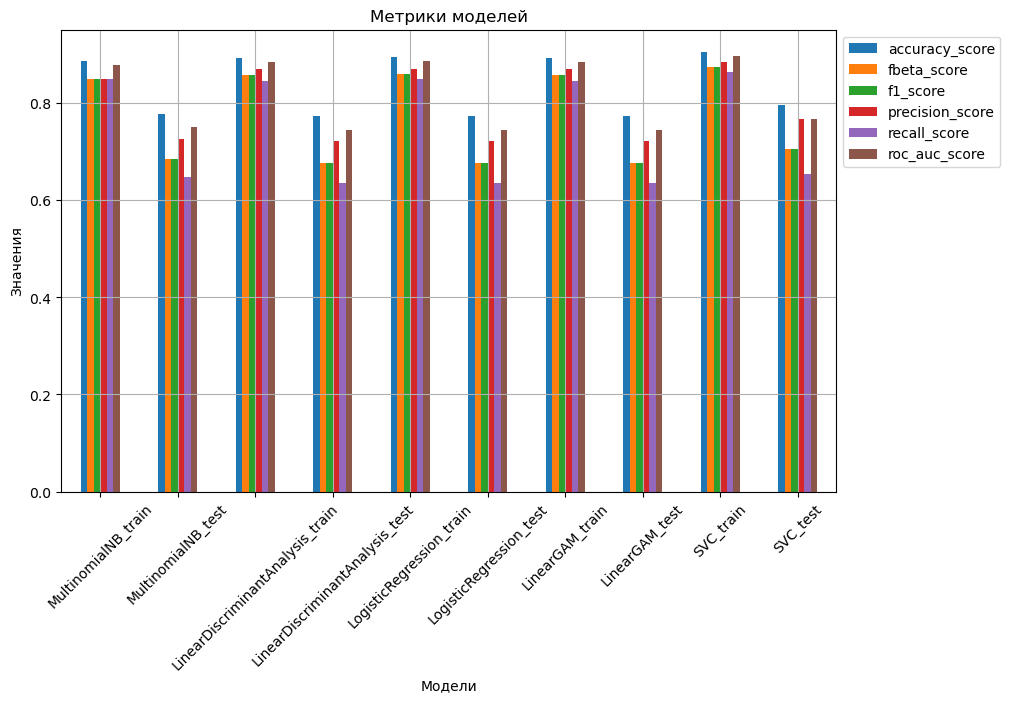

In [90]:
metrics_transposed = metrics.transpose()
metrics_transposed.plot(kind='bar',figsize=(10, 6))
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.title('Метрики моделей')
plt.xlabel('Модели')
plt.ylabel('Значения')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
Если проанализировать метрики,то наиболее близкой моделью является #метод опорных векторов SVC
Логистическая регрессия LogisticRegression.Вот какую информацию она может нам предоставить:

In [91]:
print(logit_reg.intercept_)
print('classes', logit_reg.classes_)
print(pd.DataFrame({'coeff': logit_reg.coef_[0]},
             index=X.columns))

[0.36561022]
classes [0 1]
                                 coeff
SibSp                        -0.441296
Parch                         0.025063
Age_Category_0-10             1.548865
Age_Category_11-20            0.355271
Age_Category_21-30            0.257524
Age_Category_31-40            0.532427
Age_Category_41-50           -0.285744
Age_Category_51-60           -0.223824
Age_Category_61-70           -1.064496
Age_Category_71-80           -0.754413
Fare_Category_0-130          -0.677862
Fare_Category_131-260        -1.271407
Fare_Category_261-390        -0.432811
Fare_Category_391-520         2.747690
Pclass_Category_First class   1.062438
Pclass_Category_Second class  0.065512
Pclass_Category_Third class  -0.762340
Sex_female                    2.386014
Sex_male                     -2.020404
Embarked_C                   -0.171002
Embarked_Q                    0.659121
Embarked_S                   -0.122508


Если резюмировать,то максимальный шанс на выживание имели люди в возрасте 0-10 лет(дети),женского рода(девочки)
имеющие билеты в категории стоимостью 390-520$,в первом  классе,путешествующие без родственников
(если это возможно),и севшие на пароход в порту Queenstown
А вот наименьшие шансы на выживание имели люди в возрасте от 61-70 мужского пола(старики),
купившие билеты в категории стоимостью 131-260$,в третьем классе,путешествующие с родственниками,
и севшие на пароход в порту Southampton